# Is Aristotle's Natural Philosophy objective?

## Introduction
The scientific method is one of mankind's greatest creation. It allowed us to make observations about the world around us and discern what is fact and what is fiction, making way to great advancements in humanity's quality of life. Natural philosophy is well known as the predecessor to the scientific method. In fact, what we know as science today was simply called natural philosophy in the past. There didn't used to be a distinction.

Science is considered to be pretty objective in method. We have frameworks put in place like double-blind experimentation to reduce the number of errors due to human error or bias. Most people will also agree that a well written scientific article in a journal will be more objective than an article in a magazine. Can we use methods of machine learning in natural language processing to see if natural philosophy is similarly objective compared to other schools of thought?

The [History of Philosophy dataset](https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy) will be used to make the analysis, focusing specifically on Aristotle's body of work, since he has written texts on natural philosophy and also other topics such as logic and politics with which we can make a comparison on objectivity. The subset of works will be put into a topic modelling algorithm to try and discern which sentences are part of his works on natural philosophy, and then put through a sentiment analysis algorithm measuring the subjectivity of the sentences.

In [2]:
#Setup
#Operations
import pandas as pd
import numpy as np
import sys
import os

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#NLP Cleaning
import spacy
from spacy.lang.en import English
import en_core_web_md
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#NLP Algorithms
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from textblob import TextBlob

/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
#To allow for calling local functions
path_def='/Users/safiraraharjo/Documents/GitHub/ads-spring2023-project1-safiraharjo/'
sys.path.insert(0, path_def+'lib')

## Topic Modelling
Topic Modelling is the task of using unsupervised learning to extract the main topics (represented as a set of words) that occur in a collection of documents. In this case, the collection of documents are sentences in philosophical texts and we are identifying which texts are likely to fall into the category of natural philosophy based on their topics. We will be using Latent Dirichlet Allocation (LDA) to conduct this analysis, which is a statistical model that explains a set of observations (sentences) through unobserved groups (topics), and each group explains why some parts of the data are similar using a set of words. Before the LDA can be run, the dataset first needs to be pre-processed.

In [4]:
#Read data
df = pd.read_csv(path_def+'data/philosophy_data.csv')
df.head()

title author school  \
0  Plato - Complete Works  Plato  plato   
1  Plato - Complete Works  Plato  plato   
2  Plato - Complete Works  Plato  plato   
3  Plato - Complete Works  Plato  plato   
4  Plato - Complete Works  Plato  plato   

                                      sentence_spacy  \
0   What's new, Socrates, to make you leave your ...   
1  Surely you are not prosecuting anyone before t...   
2  The Athenians do not call this a prosecution b...   
3                              What is this you say?   
4  Someone must have indicted you, for you are no...   

                                        sentence_str  \
0   What's new, Socrates, to make you leave your ...   
1  Surely you are not prosecuting anyone before t...   
2  The Athenians do not call this a prosecution b...   
3                              What is this you say?   
4  Someone must have indicted you, for you are no...   

   original_publication_date  corpus_edition_date  sentence_length  \
0                       -350                 1997              125   
1                       -350                 1997               69   
2                       -350                 1997               74   
3                       -350                 1997               21   
4                       -350                 1997              101   

                                    sentence_lowered  \
0   what's new, socrates, to make you leave your ...   
1  surely you are not prosecuting anyone before t...   
2  the athenians do not call this a prosecution b...   
3                              what is this you say?   
4  someone must have indicted you, for you are no...   

                                       tokenized_txt  \
0  ['what', 'new', 'socrates', 'to', 'make', 'you...   
1  ['surely', 'you', 'are', 'not', 'prosecuting',...   
2  ['the', 'athenians', 'do', 'not', 'call', 'thi...   
3               ['what', 'is', 'this', 'you', 'say']   
4  ['someone', 'must', 'have', 'indicted', 'you',...   

                                      lemmatized_str  
0     what be new , Socrates , to make -PRON- lea...  
1   surely -PRON- be not prosecute anyone before ...  
2   the Athenians do not call this a prosecution ...  
3                          what be this -PRON- say ?  
4   someone must have indict -PRON- , for -PRON- ...

### Data Pre-processing
Texts need to go through a series of processes before they can be input into the LDA model. Some of these processes include tokenization and lemmatization. Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning. Lemmatization is a text normalization technique that switches any kind of a word to its base root mode. In addition to that, certain parts of text such as pronouns are removed, as they do not affect output topics.

In [5]:
from nlp_cleaning import cleaner
nlp = en_core_web_md.load()
cleaner(nlp,df,df.sentence_str)

title author    school  \
0       Plato - Complete Works  Plato     plato   
1       Plato - Complete Works  Plato     plato   
2       Plato - Complete Works  Plato     plato   
3       Plato - Complete Works  Plato     plato   
4       Plato - Complete Works  Plato     plato   
...                        ...    ...       ...   
360803  Women, Race, And Class  Davis  feminism   
360804  Women, Race, And Class  Davis  feminism   
360805  Women, Race, And Class  Davis  feminism   
360806  Women, Race, And Class  Davis  feminism   
360807  Women, Race, And Class  Davis  feminism   

                                           sentence_spacy  \
0        What's new, Socrates, to make you leave your ...   
1       Surely you are not prosecuting anyone before t...   
2       The Athenians do not call this a prosecution b...   
3                                   What is this you say?   
4       Someone must have indicted you, for you are no...   
...                                                   ...   
360803  But the socialization of housework including m...   
360804  The only significant steps toward endingdomest...   
360805  Working women, therefore, have a special and v...   
360806  Moreover, under capitalism, campaigns for jobs...   
360807  This strategy calls into question the validity...   

                                             sentence_str  \
0        What's new, Socrates, to make you leave your ...   
1       Surely you are not prosecuting anyone before t...   
2       The Athenians do not call this a prosecution b...   
3                                   What is this you say?   
4       Someone must have indicted you, for you are no...   
...                                                   ...   
360803  But the socialization of housework including m...   
360804  The only significant steps toward endingdomest...   
360805  Working women, therefore, have a special and v...   
360806  Moreover, under capitalism, campaigns for jobs...   
360807  This strategy calls into question the validity...   

        original_publication_date  corpus_edition_date  sentence_length  \
0                            -350                 1997              125   
1                            -350                 1997               69   
2                            -350                 1997               74   
3                            -350                 1997               21   
4                            -350                 1997              101   
...                           ...                  ...              ...   
360803                       1981                 1981              142   
360804                       1981                 1981              117   
360805                       1981                 1981               90   
360806                       1981                 1981              199   
360807                       1981                 1981              126   

                                         sentence_lowered  \
0        what's new, socrates, to make you leave your ...   
1       surely you are not prosecuting anyone before t...   
2       the athenians do not call this a prosecution b...   
3                                   what is this you say?   
4       someone must have indicted you, for you are no...   
...                                                   ...   
360803  but the socialization of housework including m...   
360804  the only significant steps toward endingdomest...   
360805  working women, therefore, have a special and v...   
360806  moreover, under capitalism, campaigns for jobs...   
360807  this strategy calls into question the validity...   

                                            tokenized_txt  \
0       ['what', 'new', 'socrates', 'to', 'make', 'you...   
1       ['surely', 'you', 'are', 'not', 'prosecuting',...   
2       ['the', 'athenians', 'do', 'not', 'call', 'thi...   
3                    ['what', 'is', 'this', 'you', 'say']   
4      

The result of the processed texts of Aristotle can be visualized in a word cloud. Words such as 'the' and 'a' are no longer in the text, and words like 'things' and 'thing'only appear in one form.

In [6]:
aristotle = df[df.author == 'Aristotle']

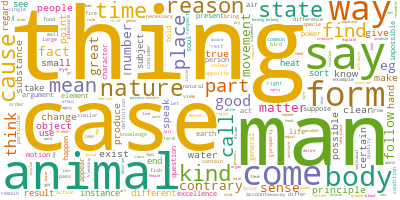

In [7]:
aristotle['cleaned_str'] = [' '.join(map(str, l)) for l in aristotle['cleaned']]
long_string = ','.join(list(aristotle['cleaned_str'].values))
wordcloud = WordCloud(background_color="white"
                      , contour_width=0.1
                      , contour_color="black"
                      , max_font_size=100
                      , random_state=42
                      , colormap="Dark2")
wordcloud.generate(long_string)
wordcloud.to_file(path_def+'figs/aristotle_wc.png')
wordcloud.to_image()

### Modelling
The first step to the modelling is removing words that appear in most of the text or appear very infrequently. Words that appear in most of the texts will make it difficult to cluster the text into topics, and words that appear very infrequently are likely to be irrelevant.

The number of topics also needs to be determined. If there is previous knowledge of the texts, the number of topics can often be determined without further analysis (e.g. if the texts are composed of articles from 5 different magazines, it can be expected that there are 5 topics). In this case however, the number of topics will be determined using an analysis of coherence scores.

There are two major types of coherence scores which will be used in this analysis. One of the most popular coherence metrics is called CV which measures the distance between words. The other, UMass coherence, measure how often two words are seen together.

In this analysis, the above steps are condensed into the `coherence_score_viz` function.

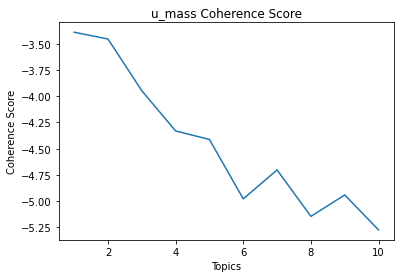

In [8]:
from coherence_modelling import coherence_score_viz
coherence_score_viz(aristotle['cleaned'],'u_mass',1,11,corpora,gensim.models.LdaMulticore,plt,CoherenceModel,path_def)

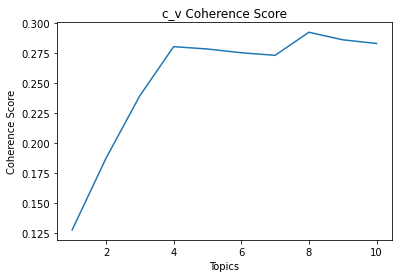

In [9]:
coherence_score_viz(aristotle['cleaned'],'c_v',1,11,corpora,gensim.models.LdaMulticore,plt,CoherenceModel,path_def)

### Results
With CV scores, there is a dramatic increase in coherence score at 4 topics. With UMass scores, there is a dramatinc decrease in coherence between 2 and 4 topics. Given that 2 topics seem to be too general, 4 seems right. However, a look at Aristotle's body of work spanning natural philosophy, theoretical philosophy (logic and metaphysics), as well as practical philosophy (politics and economics), 5 topics were chosen as there was not a large decrease in coherence scores.

In [11]:
#Number of topics
num_topics = 5

#Final LDA model after determining number of topics
id2word = corpora.Dictionary(aristotle['cleaned'])
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [id2word.doc2bow(doc) for doc in aristotle['cleaned']]

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=999)

#Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.015*"come" + 0.015*"thing" + 0.013*"tragedy" + 0.013*"say" + '
  '0.011*"great" + 0.011*"time" + 0.010*"point" + 0.010*"form" + 0.009*"state" '
  '+ 0.008*"speech"'),
 (1,
  '0.018*"animal" + 0.013*"small" + 0.013*"large" + 0.012*"kind" + '
  '0.011*"water" + 0.011*"contrary" + 0.010*"form" + 0.010*"good" + '
  '0.010*"sense" + 0.010*"reason"'),
 (2,
  '0.018*"poet" + 0.018*"man" + 0.017*"animal" + 0.014*"belong" + 0.014*"act" '
  '+ 0.014*"body" + 0.011*"change" + 0.011*"state" + 0.010*"female" + '
  '0.009*"male"'),
 (3,
  '0.021*"thing" + 0.016*"think" + 0.013*"part" + 0.013*"way" + 0.011*"cause" '
  '+ 0.011*"matter" + 0.011*"place" + 0.010*"take" + 0.010*"number" + '
  '0.009*"time"'),
 (4,
  '0.046*"man" + 0.035*"thing" + 0.033*"good" + 0.013*"case" + '
  '0.010*"excellence" + 0.010*"mean" + 0.009*"say" + 0.009*"bad" + 0.009*"law" '
  '+ 0.008*"kind"')]


The topics above look like topics 1, 2, and 3 could fall into the subject of natural philosophy.

In [12]:
#Appending the highest probability topic to each sentence
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
topic_id_list = all_topics_df.idxmax(axis=1)
aristotle['topics'] = topic_id_list

In [13]:
#Cleaning to create wordcloud
topic_wordcloud = aristotle.groupby('topics')['cleaned_str'].apply(list)
topic_wordcloud[:] = [' '.join(map(str, l)) for l in topic_wordcloud[:]]
topic_wordcloud_df=pd.DataFrame(topic_wordcloud)
topic_wordcloud_df['cleaned_str'] = topic_wordcloud_df['cleaned_str'].str.replace("thing,", "")

/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


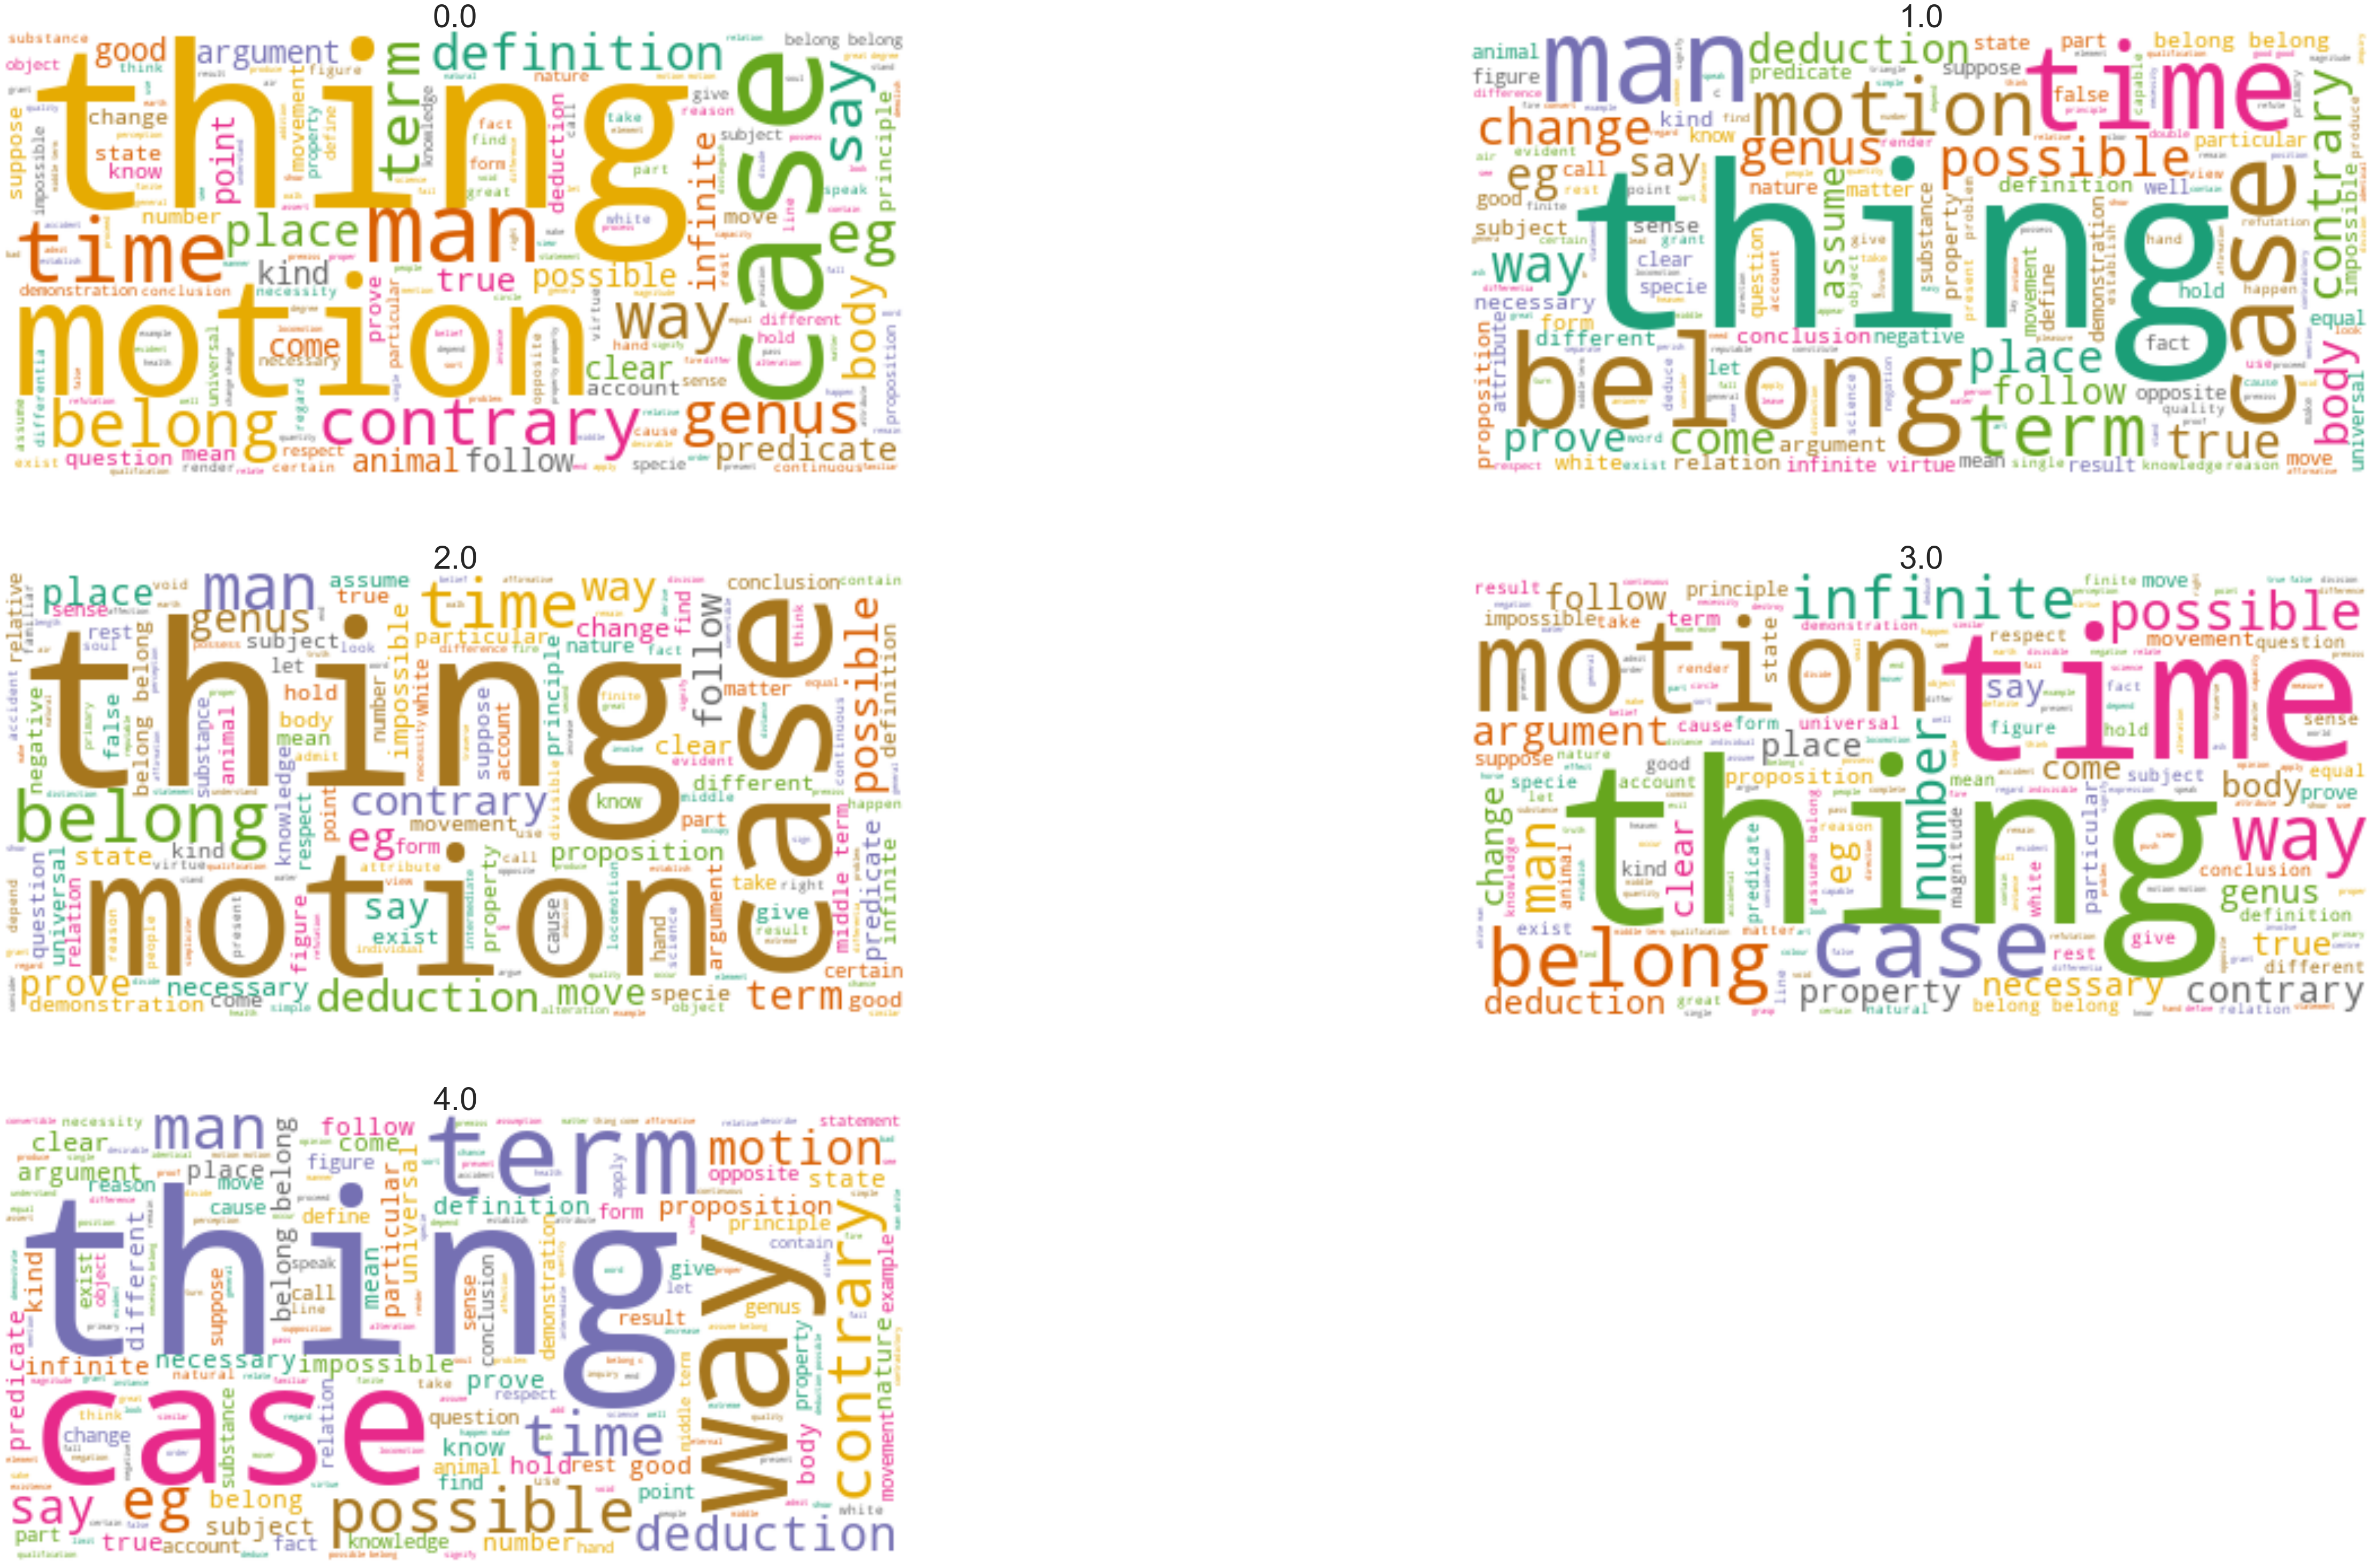

In [14]:
#Displaying wordcloud of all the topics
sns.set()
plt.rcParams['figure.figsize'] = [90, 90]

x, y = np.ogrid[:300, :300]

wordcloud = WordCloud(background_color="white", contour_width=0.1, 
                      contour_color="black",  max_font_size=100, random_state=42,
                      colormap="Dark2")

for i in range(5):
    wordcloud.generate(text=topic_wordcloud_df['cleaned_str'][i])   
    plt.subplot(5, 2, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(topic_wordcloud_df.index[i], fontdict={'fontsize': 60})
plt.savefig(path_def+'figs/topic_wc.png')
plt.show()

The wordcloud shows words like air in topic 1, genus in topic 2, and animal in topic 3. It is still difficult to determine which ones fall under natural philosophy, as they seem to have many words in common.

In [15]:
#Visualizing intertopic distance and relevant terms of topic
pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(p, path_def+'figs/pyLDAvis.html')
p

/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.066844  0.017152       1        1  24.050595
1     -0.123807 -0.036856       2        1  22.078771
0      0.009330  0.020934       3        1  19.535360
3      0.057001 -0.089144       4        1  18.051230
2     -0.009368  0.087913       5        1  16.284043, topic_info=         Term         Freq        Total Category  logprob  loglift
8         man  5794.000000  5794.000000  Default  30.0000  30.0000
114      good  3796.000000  3796.000000  Default  29.0000  29.0000
420      poet  1034.000000  1034.000000  Default  28.0000  28.0000
926   tragedy   883.000000   883.000000  Default  27.0000  27.0000
54      large  1118.000000  1118.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
101  contrary   335.918823  1520.511534   Topic5  -5.1284   0.3051
5       thing   459.218417  6199.033586   Topic5  -4.8157  -0.7876
218    nature   346.746417  2050.232219   Topic5  -5.0966   0.0379
17    subject   312.943651  1208.577465   Topic5  -5.1992   0.4638
62       true   311.723469  1176.642933   Topic5  -5.2031   0.4867

[346 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
841       2  0.050173  abundant
841       3  0.016724  abundant
841       4  0.016724  abundant
841       5  0.919834  abundant
585       1  0.123613       act
...     ...       ...       ...
362       4  0.048791     write
362       5  0.108842     write
775       3  0.693078     young
775       4  0.042390     young
775       5  0.262819     young

[1154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3])

Finally, looking at the intertopic distance, topic 2 is very far away from all the other topics, and the relevant topical keywords very much suggest it is talking about something scientific. Words like animal, bird, water, and heat appear. Sentences which have the highest probability of being in topic 2 will therefore be the subject of the next part of the analysis.

## Subjectivity Modelling
Subjectivity analysis investigates attitudes, feelings, and expressed opinions in a text. As a basic task, it classifies a text as subjective (opinion) or objective (fact). The Textblob module used in this analysis will measure subjectivity on a scale of 0 to 1, 0 being the most objective and 1 being the most subjective.

### Natural Philosophy and the Works of Aristotle

In [16]:
from subjectivity_modelling import subjectivity
subjectivity(aristotle, 12, TextBlob)

title     author     school  \
38366  Aristotle - Complete Works  Aristotle  aristotle   
38367  Aristotle - Complete Works  Aristotle  aristotle   
38368  Aristotle - Complete Works  Aristotle  aristotle   
38369  Aristotle - Complete Works  Aristotle  aristotle   
38370  Aristotle - Complete Works  Aristotle  aristotle   
...                           ...        ...        ...   
87140  Aristotle - Complete Works  Aristotle  aristotle   
87141  Aristotle - Complete Works  Aristotle  aristotle   
87142  Aristotle - Complete Works  Aristotle  aristotle   
87143  Aristotle - Complete Works  Aristotle  aristotle   
87144  Aristotle - Complete Works  Aristotle  aristotle   

                                          sentence_spacy  \
38366   When things have only a name in common and th...   
38367  Thus, for example, both a man and a picture ar...   
38368  These have only a name in common and the defin...   
38369  When things have the name in common and the de...   
38370  Thus, for example, both a man and an ox are an...   
...                                                  ...   
87140  ; which is a great advantage, since the more c...   
87141  consider the Oedipus of Sophocles, for instanc...   
87142  There is less unity in the imitation of the ep...   
87143  In saying that there is less unity in an epic,...   
87144  If, then, tragedy is superior in these respect...   

                                            sentence_str  \
38366   When things have only a name in common and th...   
38367  Thus, for example, both a man and a picture ar...   
38368  These have only a name in common and the defin...   
38369  When things have the name in common and the de...   
38370  Thus, for example, both a man and an ox are an...   
...                                                  ...   
87140  ; which is a great advantage, since the more c...   
87141  consider the Oedipus of Sophocles, for instanc...   
87142  There is less unity in the imitation of the ep...   
87143  In saying that there is less unity in an epic,...   
87144  If, then, tragedy is superior in these respect...   

       original_publication_date  corpus_edition_date  sentence_length  \
38366                       -320                 1991              139   
38367                       -320                 1991               56   
38368                       -320                 1991              207   
38369                       -320                 1991              134   
38370                       -320                 1991               52   
...                          ...                  ...              ...   
87140                       -320                 1991              137   
87141                       -320                 1991              118   
87142                       -320                 1991              308   
87143                       -320                 1991              333   
87144                       -320                 1991              324   

                                        sentence_lowered  \
38366   when things have only a name in common and th...   
38367  thus, for example, both a man and a picture ar...   
38368  these have only a name in common and the defin...   
38369  when things have the name in common and the de...   
38370  thus, for example, both a man and an ox are an...   
...                                                  ...   
87140  ; which is a great advantage, since the more c...   
87141  consider the oedipus of sophocles, for instanc...   
87142  there is less unity in the imitation of the ep...   
87143  in saying that there is less unity in an epic,...   
87144  if, then, tragedy is superior in these respect...   

                                           tokenized_txt  \
38366  ['when', 'things', 'have', 'only', 'name', 'in...   
38367  ['thus', 'for', 'example', 'both', 'man', 'and...   
38368  ['these', 'have', 'only', 'name', 'in', 'commo...   
38369  ['when', 'things', '

In [17]:
aristotle.groupby(['topics'])['subjectivity'].mean()

topics
0.0    0.315566
1.0    0.325995
2.0    0.327974
3.0    0.315465
4.0    0.335072
Name: subjectivity, dtype: float64

The average level of subjectivity in all topic groups don't differ very much. Topic 2, which seems to be closest to natural philosophy, is about average in terms of subjectivity compared to other topic groups.

### Comparison to Other Texts

In [18]:
df['cleaned_str'] = [' '.join(map(str, l)) for l in df['cleaned']]
subjectivity(df, 12, TextBlob)

title author    school  \
0       Plato - Complete Works  Plato     plato   
1       Plato - Complete Works  Plato     plato   
2       Plato - Complete Works  Plato     plato   
3       Plato - Complete Works  Plato     plato   
4       Plato - Complete Works  Plato     plato   
...                        ...    ...       ...   
360803  Women, Race, And Class  Davis  feminism   
360804  Women, Race, And Class  Davis  feminism   
360805  Women, Race, And Class  Davis  feminism   
360806  Women, Race, And Class  Davis  feminism   
360807  Women, Race, And Class  Davis  feminism   

                                           sentence_spacy  \
0        What's new, Socrates, to make you leave your ...   
1       Surely you are not prosecuting anyone before t...   
2       The Athenians do not call this a prosecution b...   
3                                   What is this you say?   
4       Someone must have indicted you, for you are no...   
...                                                   ...   
360803  But the socialization of housework including m...   
360804  The only significant steps toward endingdomest...   
360805  Working women, therefore, have a special and v...   
360806  Moreover, under capitalism, campaigns for jobs...   
360807  This strategy calls into question the validity...   

                                             sentence_str  \
0        What's new, Socrates, to make you leave your ...   
1       Surely you are not prosecuting anyone before t...   
2       The Athenians do not call this a prosecution b...   
3                                   What is this you say?   
4       Someone must have indicted you, for you are no...   
...                                                   ...   
360803  But the socialization of housework including m...   
360804  The only significant steps toward endingdomest...   
360805  Working women, therefore, have a special and v...   
360806  Moreover, under capitalism, campaigns for jobs...   
360807  This strategy calls into question the validity...   

        original_publication_date  corpus_edition_date  sentence_length  \
0                            -350                 1997              125   
1                            -350                 1997               69   
2                            -350                 1997               74   
3                            -350                 1997               21   
4                            -350                 1997              101   
...                           ...                  ...              ...   
360803                       1981                 1981              142   
360804                       1981                 1981              117   
360805                       1981                 1981               90   
360806                       1981                 1981              199   
360807                       1981                 1981              126   

                                         sentence_lowered  \
0        what's new, socrates, to make you leave your ...   
1       surely you are not prosecuting anyone before t...   
2       the athenians do not call this a prosecution b...   
3                                   what is this you say?   
4       someone must have indicted you, for you are no...   
...                                                   ...   
360803  but the socialization of housework including m...   
360804  the only significant steps toward endingdomest...   
360805  working women, therefore, have a special and v...   
360806  moreover, under capitalism, campaigns for jobs...   
360807  this strategy calls into question the validity...   

                                            tokenized_txt  \
0       ['what', 'new', 'socrates', 'to', 'make', 'you...   
1       ['surely', 'you', 'are', 'not', 'prosecuting',...   
2       ['the', 'athenians', 'do', 'not', 'call', 'thi...   
3                    ['what', 'is', 'this', 'you', 'say']   
4      

In [19]:
df.groupby('school').agg({'subjectivity': ['mean']})

subjectivity
                        mean
school                      
analytic            0.286684
aristotle           0.341157
capitalism          0.367580
communism           0.290665
continental         0.314276
empiricism          0.357706
feminism            0.361778
german_idealism     0.312720
nietzsche           0.333113
phenomenology       0.283388
plato               0.319806
rationalism         0.366719
stoicism            0.329450

Running the analysis on the overall dataset shows that the subjectivity of Aristotle's works is about average compared to other schools of thoughts. Some of the ones that are notably more objective are tha analytic and phenomenology schools of philosophy.

As a fun exercise, the same subjectivity analysis methods are applied on a dataset of [10,000 Abstracts of Covid Research Papers](https://www.kaggle.com/datasets/anandhuh/covid-abstracts) to see whether modern research papers are any more objective than philosophical texts.

In [20]:
abstracts = pd.read_csv(path_def+'data/covid_abstracts.csv')
abstracts.head()

title  \
0  Real-World Experience with COVID-19  Including...   
1  Successful outcome of pre-engraftment COVID-19...   
2  The impact of COVID-19 on oncology professiona...   
3  ICU admission and mortality classifiers for CO...   
4  Clinical evaluation of nasopharyngeal  midturb...   

                                            abstract  \
0  This article summarizes the experiences of COV...   
1  Coronavirus disease 2019  COVID-19   caused by...   
2  BACKGROUND  COVID-19 has had a significant imp...   
3  The coronavirus disease 2019  COVID-19  which ...   
4  In the setting of supply chain shortages of na...   

                                        url  
0  https://pubmed.ncbi.nlm.nih.gov/35008137  
1  https://pubmed.ncbi.nlm.nih.gov/35008104  
2  https://pubmed.ncbi.nlm.nih.gov/35007996  
3  https://pubmed.ncbi.nlm.nih.gov/35007991  
4  https://pubmed.ncbi.nlm.nih.gov/35007959

In [21]:
cleaner(nlp,abstracts,abstracts.abstract)
abstracts['cleaned_str'] = [' '.join(map(str, l)) for l in abstracts['cleaned']]

In [22]:
subjectivity(abstracts, 4, TextBlob)
abstracts['subjectivity'].mean()

0.4210568621231637

## Conclusion

Surprisingly, the abstracts of modern research papers are more subjective with a score of 0.42. Looking further into the dataset, a sentence like "The impact of the coronavirus disease 2019 (COVID-19) pandemic on well-being has the potential for serious negative consequences on work, home life, and patient care" found in one of the abstracts, is a very subjective sentence. While most people can agree the sentence is factual, serious consequences are subjective, as what one considers serious may not be considered serious by others. Conversely, a sentence by Aristotle like "Thus, for example, both a man and an ox are animals" is both factually correct but also doesn't use any subjective language. Oftentimes, modern research is geared towards getting people to take action, such as wear a mask, and using emotionally charged subjective language is affective in addition to providing factual evidence.

It can be concluded that just just because the methods of analysis used in the texts are more objective, it doesn't mean that the language used is, regardless of what the topic is.